In [1]:
import numpy as np
import sympy as sp
from sympy import Symbol, expand
from scipy.integrate import solve_ivp
import time

import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
import sys
sys.path.insert(0,'..')

from core.Lie import LieLayer
from core.Lie_map_builder import LieMapBuilder

Using TensorFlow backend.


In [2]:
def vdp_system(t, state, k=1):
    x = state[0]
    dx= state[1]
    return np.array([dx, dx-k*x*x*dx - x])

def solve_num(x0, t):
    X = solve_ivp(vdp_system, [0, t], x0, max_step=0.01)
    return X.y.T, X.t

def plot_num():
    for x0 in X0:
        X,_= solve_num(x0, T)
        plt.plot(X[:, 0], X[:, 1], 'r-', alpha = 0.7)
    return

In [4]:
X0 = np.array([[1, 2],
               [2, -2],
               [-3, -3],
               [-2, 4]], dtype=float).reshape((-1, 2))/1
T = 7

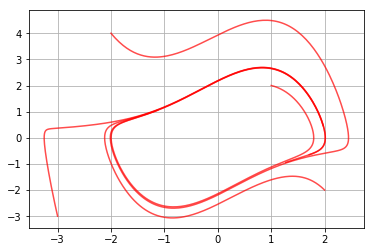

In [5]:
plot_num()
plt.grid()
plt.show()

In [31]:
def lie_map():
    R0 = np.array([[0.], [0.]])
    R1 = np.array([[ 0.99995067, 0.01004917],
                   [-0.01004917, 1.00999984]])
    R2 = np.array([[0.,0.,0.],
                   [0.,0.,0.]])
    R3 = np.array([[ 1.59504733e-07, -4.94822066e-05, 3.20576750e-07, -7.90629025e-10],
                   [ 4.94821629e-05, -1.00975145e-02, -9.96173322e-05, -3.30168067e-07]])
    return [R0, R1, R2, R3]

def euler_map(dt=0.01):
    R0 = np.array([[0.], [0.]])
    R1 = np.array([[ 1, dt],
                   [-dt, 1+dt]])
    R2 = np.array([[0.,0.,0.],
                   [0.,0.,0.]])
    R3 = np.array([[ 0,   0, 0, 0],
                   [ 0, -dt,   0, 0]])
    return [R0, R1, R2, R3]

x = Symbol('x')
dx = Symbol('dx')
state = np.array([x,dx])
right_hand_side = [dx, dx-100*x*x*dx - x]
order = 3
dim = 2
map_builder = LieMapBuilder(state, right_hand_side, order=order)
    
def get_lie_net(R):
    W = map_builder.convert_weights_to_full_nn(R)
    map1 = LieLayer(output_dim = dim, order = order, input_shape = (dim,))
    model = Sequential()
    model.add(map1)
    map1.set_weights(W)
    return model

def solve_net(model, line='b.', epoch_n = 700):
    X = np.ones((epoch_n+1, X0.shape[0], dim))
    X[0,:,:] = X0
    for i in xrange(epoch_n):
        X[i+1] = model.predict(X[i])
        
    plt.plot(X[::10,:,0], X[::10,:,1], line, markersize=3, linewidth=1)
    return

[x dx]
[dx, -100*dx*x**2 + dx - x]


In [104]:
R = map_builder.getInitR()
h = 0.001
N = 10
R = map_builder.propogate(h, N, verbose=False)

0 10
1 10
2 10
3 10
4 10
5 10
6 10
7 10
8 10
9 10


Instructions for updating:
Colocations handled automatically by placer.


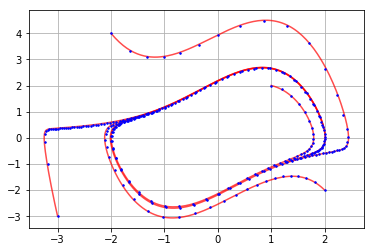

In [7]:
model_lie = get_lie_net(lie_map())
#model_lie = get_lie_net(R)
plot_num()
solve_net(model_lie, 'b.')
plt.grid()

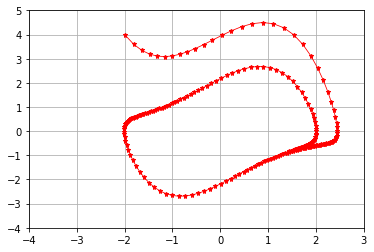

In [36]:
T = 1000*0.01
Xtrain, t = solve_num(X0[-1], T)
tt = np.arange(0, T+0.02, 0.01)
#Xtrain[:,0] = np.interp(tt, t, Xtrain[:,0])
#Xtrain[:,1] = np.interp(tt, t, Xtrain[:,1])
#plt.plot(Xtrain[::10], '*')
Xtrain[:,0] = np.interp(tt, t, Xtrain[:,0])
Xtrain[:,1] = np.interp(tt, t, Xtrain[:,1])
plt.plot(Xtrain[::5,0], Xtrain[::5,1], 'r*-', markersize=5, linewidth=0.8)

plt.xlim([-4, 3])
plt.ylim([-4, 5])
plt.grid()

In [14]:
def createLieNet(inputDim=2, outputDim=2, order=3):
    model = Sequential()
    model.add(LieLayer(output_dim = outputDim, order=order,
                      input_shape = (inputDim,)))
    opt = keras.optimizers.Adamax(lr=0.02, beta_1=0.99,
                                  beta_2=0.99999, epsilon=1e-1, decay=0.0)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [15]:
def get_mask(b):
    b = b.reshape((2, -1))
    b_mask = [b[:, 0], b[:, 1:3], b[:, 3:7], b[:, 7:]]
    b_mask = [b.T for b in b_mask]
    return b_mask

In [16]:
import Van_der_Pole as vdp
from QUBO import qbsolve, solve_dwave
def learn(epochs, isQUBO):
    learn_net = createLieNet()
    loss=[]
    for i in xrange(epochs):
        history = learn_net.fit(Xtrain[:-1], Xtrain[1:], epochs=1, verbose=0)
        loss.append(history.history['loss'][-1])
        W = learn_net.get_weights()
        if isQUBO:
            Q = vdp.calc_Q_array(Xtrain[:-1], Xtrain[1:], [w.T for w in W])
            #b = solve_dwave(Q)
            b,_ = qbsolve(Q)
            M = get_mask(b)
            #print '----------------------'
            #print b.reshape((2, -1))
            learn_net.set_weights([w*m for w, m in zip(W, M)])
    #print b.reshape((2, -1))
    print loss[-1]
    return learn_net, loss

Instructions for updating:
Use tf.cast instead.
2.260235527006938e-05
1.6412597665842006e-07


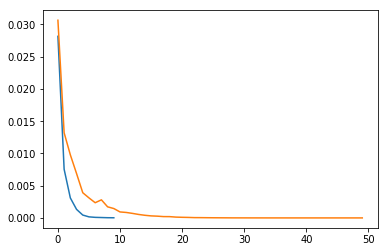

In [17]:
#learn_netQ, lossQ = learn(10, True)
learn_net, loss = learn(50, False)

plt.plot(lossQ)
plt.plot(loss)

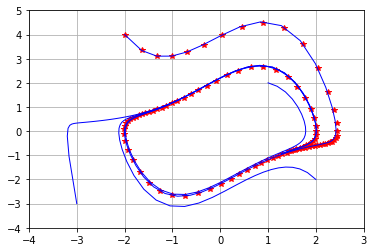

In [38]:
plt.plot(Xtrain[::10,0], Xtrain[::10,1], 'r*')
#solve_net(model_lie, 'b-')
#solve_net(learn_netQ, 'r-')
solve_net(learn_net, 'b-')
plt.xlim([-4, 3])
plt.ylim([-4, 5])
plt.grid()